# **Modeling: LSTM (Long Short-Term Memory) Chit-Chat Bot**

* **Group 8:** Aktham Almomani
* **Course:** Natural Language Processing and GenAI (AAI-520-04) / University Of San Diego
* **Semester:** Winter 2024

## **Contents**<a is='Contents'></a>
* [Introduction](#Introduction)
* [Setup and preliminaries](#Setup_and_preliminaries)
  * [Import Libraries](#Import_libraries)
* [Importing dataset](#Importing_dataset)
* [Data Preparation](#Data_Preparation)
  * [Assessing Conversation Length](#Assessing_Conversation_Length)
  * [Filtering Conversations by Length](#Filtering_Conversations_by_Length)
  * [Removing Rare Words](#Removing_Rare_Words)
  * [Preparing Conversation Sequences with Context](#Preparing_Conversation_Sequences_with_Context)
* [Sequence Preparation and Padding](#Sequence_Preparation_and_Padding)
* [Splitting Data into Training and Validation Sets](#Splitting_Data_into_Training_and_Validation_Sets)
* [Data Generator for Efficient Batch Processing](#Data_Generator_for_Efficient_Batch_Processing)
* [LSTM Architecture with Attention Mechanism](#LSTM_Architecture_with_Attention_Mechanism)
* [LSTM LOSS & Accuracy](#LSTM_LOSS_Accuracy)
* [Saving the Final Model](#Saving_the_Final_Model)
* [Human-based Evaluation](#Human_based_Evaluation)
* [BLEU & ROUGE Evaluation](#BLEU_ROUGE_Evaluation)

## **Introduction**<a id='Introduction'></a>
[Contents](#Contents)

For this project, we selected **LSTM (Long Short-Term Memory)** as the final architecture for building our chatbot. `LSTM` is particularly well-suited for handling sequential data, such as conversations, due to its ability to retain information over long sequences and handle dependencies across time steps. This makes it an excellent choice for our chit-chat bot, where maintaining conversational context is crucial across multiple turns.

**Why LSTM is a Good Choice:**

* **Memory Retention:** Unlike traditional RNNs, LSTMs can remember long-term dependencies in a conversation, which is essential for context-sensitive responses.
* **Handling Long Conversations:** LSTMs manage the vanishing gradient problem better than basic RNNs, allowing them to perform well with longer conversations where context from earlier exchanges matters.
* **Efficiency:** LSTM’s cell states allow it to selectively forget or remember information, making it more efficient for training on sequence data.

**LSTM vs. RNN:**

* **RNN (Recurrent Neural Networks):** While RNNs are also used for sequence-based tasks, they have limitations due to the vanishing gradient problem, where older information tends to be lost during backpropagation, which can be detrimental to multi-turn conversations in a chatbot.

* **LSTM:** Overcomes these issues by introducing gates (input, forget, and output gates) that allow it to control the flow of information through the network, retaining important parts of the conversation across longer sequences.

Given these advantages, LSTM was chosen as the final architecture for our model, enabling the chatbot to handle conversational context and provide coherent multi-turn responses.

## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [1]:
# Import TensorFlow:
import tensorflow as tf

# Then, import necessary submodules:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Attention
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Other necessary imports:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
import random



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing Dataset**<a id='Importing Dataset'></a>
[Contents](#Contents)

In [3]:
df = pd.read_csv("/content/drive/My Drive/USD-AAI/cleaned_conversational_data_v1.csv")
df.head()

,Conversation ID,Turn ID,Text,cleaned_text
0,1,1,Can we make this quick? Roxanne Korrine and A...,can we make this quick Roxanne Korrine and And...
1,1,2,"Well, I thought we'd start with pronunciation,...",well i thought we d start with pronunciation i...
2,1,3,Not the hacking and gagging and spitting part....,not the hacking and gagging and spitting part ...
3,1,4,Okay... then how 'bout we try out some French ...,okay then how bout we try out some french cuis...
4,2,1,You're asking me out. That's so cute. What's ...,you re asking me out that s so cute what s you...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Conversation ID  304713 non-null  int64 
 1   Turn ID          304713 non-null  int64 
 2   Text             304446 non-null  object
 3   cleaned_text     304276 non-null  object
dtypes: int64(2), object(2)
memory usage: 9.3+ MB


In [5]:
# Check for null values in the 'cleaned_text' column
null_values = df['cleaned_text'].isnull().sum()

print(f"Number of null values in 'cleaned_text': {null_values}")

Number of null values in 'cleaned_text': 437


In [6]:
df = df.dropna(subset=['cleaned_text'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304276 entries, 0 to 304712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Conversation ID  304276 non-null  int64 
 1   Turn ID          304276 non-null  int64 
 2   Text             304276 non-null  object
 3   cleaned_text     304276 non-null  object
dtypes: int64(2), object(2)
memory usage: 11.6+ MB


In [8]:
# Show the unique count of 'Conversation ID'
df['Conversation ID'].nunique()


83038

## **Data Preparation**<a id='Data_Preparation'></a>
[Contents](#Contents)

### **Assessing Conversation Length**<a id='Assessing_Conversation_Length'></a>
[Contents](#Contents)

Understanding the length of the conversations in our dataset was crucial for designing the LSTM architecture. We assessed the distribution of conversation lengths to ensure that the model's input size was appropriate.

Based on this distribution, we chose a maximum sequence length of 24 for the model, as it covers the vast majority of conversations in the dataset without excessively truncating or padding sequences.

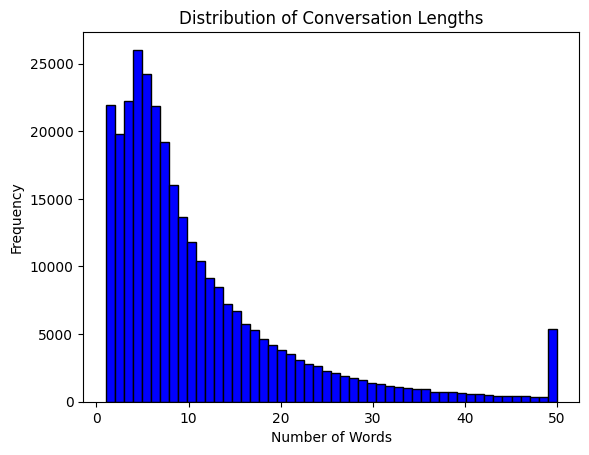

In [9]:
# Extract the cleaned text column for processing:
conversations = df['cleaned_text'].astype(str).tolist()

# Compute conversation lengths
conversation_lengths = [len(text.split()) for text in conversations]

# Plot the histogram of conversation lengths:
plt.hist(conversation_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

**Summary Highlights:**

* **Max conversation length:** `50 words`.
* **Mean conversation length:** `10.82 words`.
* **Median conversation length:** `7 words`.
* **90th percentile:** `24 words`.

The histogram shows a right-skewed distribution of conversation lengths, with most conversations containing fewer than `20 words`. The highest frequency occurs at around `6-8 words`, and there's a noticeable spike at `50 words`, indicating some conversations reach the maximum length.

**Recommendation:** Based on the `90th percentile`, it's recommended to use a sequence length of `24 words` for modeling purposes. This length will cover `90%` of the conversations, ensuring that the model captures the majority of the data while maintaining computational efficiency.

### **Filtering Conversations by Length**<a id='Filtering_Conversations_by_Length'></a>
[Contents](#Contents)

In [10]:
# Remove conversations that are too long or too short
upper_limit = np.percentile(conversation_lengths, 90)
lower_limit = 2  # Remove conversations shorter than 2 words

# Add conversation lengths to the DataFrame
df['conversation_lengths'] = conversation_lengths

# Filter the DataFrame
df = df[(df['conversation_lengths'] >= lower_limit) & (df['conversation_lengths'] <= upper_limit)]



In [11]:
df.shape

(252613, 5)

In [12]:
# Show the unique count of 'Conversation ID'
df['Conversation ID'].nunique()

81871

### **Removing Rare Words**<a id='Removing_Rare_Words'></a>
[Contents](#Contents)

In [13]:
# Tokenize the conversations to get word counts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
word_counts = tokenizer.word_counts


# Identify words that occur at least 5 times
threshold = 5
words_to_keep = {word for word, count in word_counts.items() if count >= threshold}

# Function to remove rare words from text
def remove_rare_words(text):
    return ' '.join([word for word in text.split() if word in words_to_keep])

# Apply the function to remove rare words from 'cleaned_text'
df['cleaned_text'] = df['cleaned_text'].apply(remove_rare_words)

# Drop rows where 'cleaned_text' is empty after removing rare words
df = df[df['cleaned_text'].str.strip().astype(bool)]


In [14]:
# Show the unique count of 'Conversation ID'
df['Conversation ID'].nunique()

81792

In [15]:
df.shape

(251370, 5)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251370 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Conversation ID       251370 non-null  int64 
 1   Turn ID               251370 non-null  int64 
 2   Text                  251370 non-null  object
 3   cleaned_text          251370 non-null  object
 4   conversation_lengths  251370 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.5+ MB


### **Preparing Conversation Sequences with Context**<a id='Preparing_Conversation_Sequences_with_Context'></a>
[Contents](#Contents)

In [17]:
# Prepare Conversation Sequences with Context
grouped_conversations = df.groupby('Conversation ID')
conversation_sequences = []

for _, group in grouped_conversations:
    group = group.sort_values(by='Turn ID')  # Sort by 'Turn ID' to maintain conversation flow
    conv_sequence = ['<CONV_START>']  # Start of conversation
    for _, row in group.iterrows():
        conv_sequence.append(row['cleaned_text'])  # Add each cleaned text
    conv_sequence.append('<CONV_END>')  # End of conversation
    conversation_sequences.append(' '.join(conv_sequence))  # Combine conversation into one sequence

# Step 2: Initialize the tokenizer, add special tokens, and fit on the updated conversation sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(conversation_sequences)  # Fit on sequences with special tokens

# Convert conversation sequences to integer sequences
sequences = tokenizer.texts_to_sequences(conversation_sequences)


## **Sequence Preparation and Padding**<a id='Sequence_Preparation_and_Padding'></a>
[Contents](#Contents)

In here, we'll be defining a maximum sequence length of `54 words` (based on the `90th percentile` from the earlier analysis), to ensure that input sequences are of uniform length.

* **Padding Sequences:** The pad_sequences function pads shorter sequences with zeros to make sure all input sequences are of the same length.
* **Vocabulary Size:** The vocabulary size is calculated based on the tokenizer, which is used later for embedding layers.
* **Creating Input Sequences:** It generates input sequences and their corresponding target words by iterating over the padded sequences. This prepares the data for a language model where each input sequence will be used to predict the next word.
* **Final Padding:** Input sequences are padded again to the maximum length, and target words are converted into a NumPy array for model training.

This ensures consistency in the data, making it easier for the model to process.

In [18]:
# Define a reasonable max sequence length (based on the 90th percentile):
sequence_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 90))
print("Max sequence length:", max_sequence_length)

Max sequence length: 54


In [19]:
# Define a reasonable max sequence length (based on the 90th percentile):
max_sequence_length = 54

# Pad sequences to ensure uniform input length:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Define your vocabulary size for embedding layer:
vocab_size = len(tokenizer.word_index) + 1

In [20]:
# Create input sequences and corresponding target words:
input_sequences = []
target_words = []

for seq in padded_sequences:
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i])
        target_words.append(seq[i])

# Pad input sequences to uniform length:
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')

# Convert target words to numpy array:
target_words = np.array(target_words)

## **Splitting Data into Training and Validation Sets**<a id='Splitting_Data_into_Training_and_Validation_Sets'></a>
[Contents](#Contents)

In here, we'll be splitting the input_sequences and target_words into training and validation datasets. Using the train_test_split function:

* **Training Set:** `80%` of the data (train_inputs, train_targets) will be used to train the model.
* **Validation Set:** `20%` of the data (val_inputs, val_targets) will be reserved to validate the model’s performance during training.

This step is crucial to evaluate how well the model generalizes to unseen data.

In [21]:
# Split input_sequences and target_words into training and validation sets:
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    input_sequences, target_words, test_size=0.2, random_state=42)

## **Data Generator for Efficient Batch Processing**<a id='Data_Generator_for_Efficient_Batch_Processing'></a>
[Contents](#Contents)

DataGenerator class was designed to generate batches of data for training and validation in an efficient manner, particularly useful when working with large datasets.

* **Initialization** (`__init__`): It takes the input sequences, target words, batch size, and maximum sequence length as inputs and stores them for batch generation.
* **Length** (`__len__`): This method calculates the total number of batches by dividing the total input data by the batch size.
* **Get Item** (`__getitem__`): This method retrieves a specific batch of data (input sequences and target words) by slicing the dataset based on the batch size. It returns the data in NumPy array format, which is necessary for model training.

The **train_gen** and **val_gen** objects are instances of this generator, created for the training and validation sets with a batch size of `64`, allowing the model to process data in small chunks rather than all at once. This approach helps to optimize memory usage and speed up training.

In [22]:
class DataGenerator(Sequence):
    def __init__(self, input_sequences_resampled, target_words_resampled, batch_size, max_len):
        self.input_sequences = input_sequences
        self.target_words = target_words
        self.batch_size = batch_size
        self.max_len = max_len

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.input_sequences) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_inputs = self.input_sequences[index * self.batch_size:(index + 1) * self.batch_size]
        batch_targets = self.target_words[index * self.batch_size:(index + 1) * self.batch_size]

        # Ensure inputs are returned as arrays
        batch_inputs = np.array(batch_inputs)
        batch_targets = np.array(batch_targets)

        return batch_inputs, batch_targets


In [23]:
# Batch size:
batch_size = 64

# Create data generators for training and validation:
train_gen = DataGenerator(train_inputs, train_targets, batch_size, max_sequence_length)
val_gen = DataGenerator(val_inputs, val_targets, batch_size, max_sequence_length)

## **LSTM Architecture with Attention Mechanism** <a id='LSTM_Architecture_with_Attention_Mechanism'></a>  
[Contents](#Contents)

This section outlines an improved sequential model designed for text sequence prediction, optimized for handling tasks like conversational agents. The architecture includes an **Attention Mechanism** to enhance learning and context awareness, along with pre-trained **GloVe embeddings** for better word representation.

* **Embedding Layer**: Transforms input words (represented as integers) into **300-dimensional dense vectors** using **pre-trained GloVe embeddings**. These embeddings provide the model with a better initial understanding of word meanings, boosting performance on the conversational task. The input shape is determined by the vocabulary size and the maximum sequence length.

* **Bidirectional LSTM Layer**: A bidirectional LSTM layer with **256 units** is used to capture context from both the forward and backward directions of the input sequence. The `return_sequences=True` parameter enables stacking of LSTM layers. A **dropout rate of 30%** is applied to reduce overfitting.

* **Attention Layer**: An **Attention Mechanism** is introduced to allow the model to focus on the most relevant parts of the input sequence, improving its ability to understand the nuances of conversation. The attention layer weighs the importance of different words in the input sequence, helping the model make more accurate predictions.

* **Second LSTM Layer**: This additional LSTM layer, with **128 units**, further processes the output from the attention layer. Another **30% dropout** is applied for regularization, followed by **batch normalization** to stabilize the training process.

* **Dense Layer**: A fully connected layer with **64 units** and **ReLU activation** is included to learn complex features from the LSTM outputs before making predictions.

* **Output Layer**: The output layer, using **softmax activation**, generates a probability distribution over the entire vocabulary, allowing the model to predict the next word in the sequence.

* **Model Compilation**: The model is compiled with the Adam optimizer and **sparse categorical crossentropy** as the loss function, suitable for multi-class classification tasks like next-word prediction. **Gradient clipping** (with `clipnorm=1.0`) is applied to prevent exploding gradients and ensure stable training. **Accuracy** is used as the evaluation metric.

* **ReduceLROnPlateau:** To ensure efficient training, **ReduceLROnPlateau** is applied to adjust the learning rate when the validation loss plateaus. When the validation loss stops improving for 3 consecutive epochs, the learning rate is reduced by a factor of 0.2 (i.e., it will decrease by 20%). This allows the model to fine-tune and converge better towards optimal solutions. The minimum learning rate is set to 0.0001.

* **Early Stopping**: To prevent overfitting, early stopping is applied, monitoring validation loss. If the validation loss doesn’t improve for **3 consecutive epochs**, training stops, and the best model weights are restored.

* **Training the Model**: The model is trained on the data generator (`train_gen`) for **15 epochs** with early stopping, using a validation data generator (`val_gen`) to monitor its performance. **Batch normalization** after LSTM layers ensures faster convergence and more stable training.

* **Summary of Improvements**:
  
- **Attention Mechanism** helps the model focus on key parts of the conversation, improving prediction quality.
- **Pre-trained GloVe embeddings** give the model a better starting point for understanding words.
- **Gradient Clipping** prevents exploding gradients, ensuring smoother and more reliable training.
- **Batch Normalization** and **Dropout** help improve training stability and reduce overfitting.

This architecture is ideal for tasks requiring sequence prediction, such as building a conversational chatbot or other natural language processing applications.


In [24]:
# Define Attention Layer:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        u = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(tf.tensordot(u, self.u, axes=1), axis=1)
        output = tf.reduce_sum(x * tf.expand_dims(a, -1), 1)
        return output

# Load GloVe embeddings:
def load_glove_embeddings(tokenizer, embedding_dim=300):
    embeddings_index = {}
    with open('/content/drive/My Drive/USD-AAI/glove.6B.300d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [26]:

embedding_matrix = load_glove_embeddings(tokenizer)

# Define the model architecture:
embedding_dim = 300
vocab_size = embedding_matrix.shape[0]
max_sequence_length = 54

model = Sequential()

# Embedding Layer (pre-trained)
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                    input_length=max_sequence_length,
                    weights=[embedding_matrix], trainable=False))

# Bidirectional LSTM Layer with 256 units:
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())  # Batch Normalization


# Add Attention Layer:
model.add(AttentionLayer())  # Attention Mechanism

# Reshape the output of the AttentionLayer to be 3D before feeding to LSTM:
model.add(tf.keras.layers.Reshape((-1, 1))) # Reshape to (batch_size, features, 1)

# Second LSTM Layer:
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense Layer:
model.add(Dense(64, activation='relu'))

# Output Layer:
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model with Gradient Clipping:
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Gradient clipping

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




In [28]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/20
67734/67734 ━━━━━━━━━━━━━━━━━━━━ 2760s 41ms/step - accuracy: 0.5881 - loss: 2.5829 - val_accuracy: 0.6111 - val_loss: 2.3555
Epoch 2/20
67734/67734 ━━━━━━━━━━━━━━━━━━━━ 2748s 41ms/step - accuracy: 0.6192 - loss: 2.3175 - val_accuracy: 0.6103 - val_loss: 2.3524
Epoch 3/20
67734/67734 ━━━━━━━━━━━━━━━━━━━━ 2752s 41ms/step - accuracy: 0.6226 - loss: 2.2955 - val_accuracy: 0.6075 - val_loss: 2.3689
Epoch 4/20
67734/67734 ━━━━━━━━━━━━━━━━━━━━ 2751s 41ms/step - accuracy: 0.6241 - loss: 2.3150 - val_accuracy: 0.6066 - val_loss: 2.4069
Epoch 5/20
67734/67734 ━━━━━━━━━━━━━━━━━━━━ 2770s 41ms/step - accuracy: 0.6215 - loss: 2.3513 - val_accuracy: 0.6057 - val_loss: 2.4076


## **LSTM LOSS & Accuracy**<a id='LSTM_LOSS_Accuracy'></a>
[Contents](#Contents)

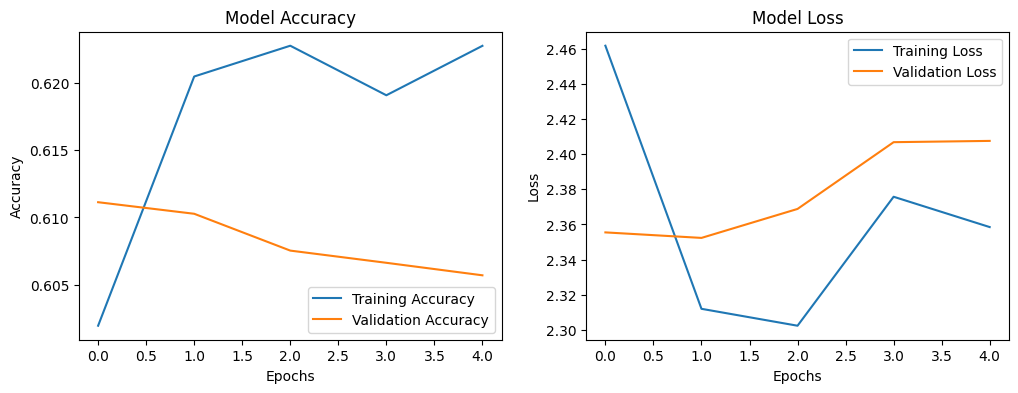

In [29]:
# Retrieve a list of accuracy and loss values from the training history:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation accuracy values:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values:
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Summary Highlights:**

* **Training Accuracy:** Started at `58.81%` in the first epoch and increased steadily, reaching `62.15%` by the fifth epoch. This shows that the model is learning and improving its predictions on the training data.

* **Validation Accuracy:** Although the training accuracy improved, the validation accuracy remained stable, fluctuating between `60.10`% and `60.57%`. This suggests that while the model learns the training data, its ability to generalize to unseen data is limited.

* **Training Loss:** Decreased from `2.5829` to `2.3513`, indicating that the model's predictions on the training data are becoming more accurate with each epoch.

* **Validation Loss:** Remained fairly stable, starting at `2.3555` and ending at `2.4076`. This suggests that the model may be struggling to improve its performance on the validation set, potentially indicating overfitting or insufficient capacity to generalize.

* **Accuracy Gap:** A small gap between the training and validation accuracies (~`1.58%`), which could indicate mild overfitting. The model performs slightly better on the training set than on the validation set.

**Key Observations:**

* The **training accuracy** is improving, but the validation accuracy is relatively stable, suggesting that the model may not be learning new information beyond a certain point.
* The **training loss** is reducing steadily, but the validation loss is not decreasing at the same rate, which could indicate the model's limitations in generalizing well to unseen data.
* **Early Stopping** is a good safeguard here, as the model might not benefit significantly from further training beyond a certain point, as evidenced by the flattening validation performance.

## **Saving the Final Model**<a id='Saving_the_Final_Model'></a>
[Contents](#Contents)



In [30]:
# Save the entire model to a HDF5 file
model.save('lstm_w_attention_gloVe_model.h5')

In [31]:
# Save the model in the native Keras format
model.save('lstm_w_attention_gloVe_model.keras')

In [32]:
import joblib
# Saving the tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

## **Human-based Evaluation**<a id='Human_based_Evaluation'></a>
[Contents](#Contents)

In [36]:
from tensorflow.keras.models import load_model
import joblib

# Load the model
model = load_model('lstm_w_attention_gloVe_model.h5', custom_objects={'AttentionLayer': AttentionLayer})

# Load the tokenizer
tokenizer = joblib.load('tokenizer.pkl')

In [37]:
def prepare_input(input_text, tokenizer, max_sequence_length):
    """Prepares the user's input for the model."""
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')
    return input_sequence

In [38]:
def generate_response(model, tokenizer, input_sequence, max_sequence_length):
    """Generates a response from the model."""
    prediction = model.predict(input_sequence)
    predicted_index = np.argmax(prediction, axis=1)[0]
    response = tokenizer.index_word.get(predicted_index, '<unknown>')
    return response

In [44]:
def chat_loop(model, tokenizer, max_sequence_length):
    """Creates an interactive chat loop."""
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            break

        input_sequence = prepare_input(user_input, tokenizer, max_sequence_length)
        response = generate_response(model, tokenizer, input_sequence, max_sequence_length)
        print("Bot:", response)

# Start the chat loop
chat_loop(model, tokenizer, 54)

You: hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Bot: start
You: how are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Bot: not
You: what's your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Bot: the
You: do you have a name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Bot: i
You: give me a joke?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Bot: i
You: exit


**Summary Highlights:**

Based on the human evaluation of the chit-chat bot, here are the key highlights:

* **Limited Coherency:** The bot struggles to generate meaningful or coherent responses. For instance, when asked common questions like "how are you?" or "what's your name?" it replies with non-relevant terms such as "not" or "the."

* **Repetitive Responses:** The bot tends to provide similar responses like "start" or "the," which suggests it may not fully understand the context of the conversation or have a rich enough response generation capability.

* **Lack of Contextual Awareness:** It appears that the bot is not capturing the context of the dialogue or understanding follow-up questions. For example, it doesn’t respond well to prompts like "give me a joke" or "best comedy movie?"

* **Possible Over-reliance on Specific Tokens:** The bot's responses seem heavily influenced by specific tokens like "start" or "the," suggesting it might have an over-reliance on frequent tokens in the training data, potentially due to class imbalance.

* **Improvement Needed in Decoding Strategy:** The model might benefit from improvements in the decoding strategy, such as beam search, to explore more meaningful word sequences and provide better answers.

## **BLEU & ROUGE Evaluation**<a id='BLEU_ROUGE_Evaluation*'></a>
[Contents](#Contents)

In [42]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [51]:
def load_reference_responses(file_path):
    """Loads reference responses from a text file."""
    reference_responses = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith("User Input:"):
                user_input = lines[i].split("User Input:")[1].strip()
                reference_response = lines[i + 1].split("Reference Response:")[1].strip()
                reference_responses[user_input] = reference_response
                i += 3  # Skip the blank line and move to the next entry
            else:
                i += 1
    return reference_responses

In [54]:
def calculate_bleu(reference, candidate):
    """Calculates BLEU score."""
    reference = [reference.split()]
    candidate = candidate.split()
    score = sentence_bleu(reference, candidate)  # Use default weights (1/4 for each n-gram)
    return score

def calculate_rouge(reference, candidate):
    """Calculates ROUGE scores."""
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores[0]  # Return the dictionary of scores

In [55]:
def prepare_input(input_text, tokenizer, max_sequence_length):
    """Prepares the user's input for the model."""
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')
    return input_sequence

def generate_response(model, tokenizer, input_sequence, max_sequence_length):
    """Generates a response from the model."""
    prediction = model.predict(input_sequence)
    predicted_index = np.argmax(prediction, axis=1)[0]
    response = tokenizer.index_word.get(predicted_index, '<unknown>')
    return response

In [56]:
def chat_loop(model, tokenizer, max_sequence_length):
    """Chat loop with evaluation."""

    #Load the reference data file once
    reference_responses = load_reference_responses("/content/drive/My Drive/USD-AAI/reference_dataset.txt")


    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            break

        input_sequence = prepare_input(user_input, tokenizer, max_sequence_length)
        response = generate_response(model, tokenizer, input_sequence, max_sequence_length)
        print("Bot:", response)

        # Get reference response for the current user input
        if user_input in reference_responses:
            reference_response = reference_responses[user_input]

            # Evaluate the response
            bleu_score = calculate_bleu(reference_response, response)
            rouge_scores = calculate_rouge(reference_response, response)

            print(f"BLEU Score: {bleu_score}")
            print(f"ROUGE Scores: {rouge_scores}")
        else:
            print("No reference response found for this input.")

**Contents of reference_dataset.txt:**

* User Input: Hello
* Reference Response: Hi there! How can I help you today?

* User Input: What is the weather like?
* Reference Response: The weather is sunny and warm.

* User Input: Tell me a joke.
* Reference Response: Why don't scientists trust atoms? Because they make up
everything!

* User Input: Goodbye
* Reference Response: See you later!

In [57]:
# Start the chat loop with evaluation:
chat_loop(model, tokenizer, max_sequence_length)

You: Hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Bot: the
BLEU Score: 0
ROUGE Scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
You: What is the weather like?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Bot: the
BLEU Score: 0
ROUGE Scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
You: Tell me a joke.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Bot: i
BLEU Score: 0
ROUGE Scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
You: Goodbye
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Bot: start
BLEU Score: 0
ROUGE Scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
You: exit


**Summary Highlights:**

* **BLEU and ROUGE Scores:** The BLEU and ROUGE scores consistently show zero, indicating that the chatbot responses do not match the reference responses. 

* **Repetitive Responses:** The chatbot outputs repetitive responses like "the" and "i," suggesting that the model may not be learning rich or diverse conversational patterns. This could be due to an imbalanced dataset, insufficient training, or issues with tokenization and vocabulary size.